In [ ]:
pip install fundamentus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.0 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import fundamentus
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [ ]:
def obter_preco_acao(ticker, periodo):
    # Obter dados da ação
    acao = yf.Ticker(ticker)

    # Obter dados do histórico recente
    dados_historicos = acao.history(period=periodo)
    dados_historicos = dados_historicos[["Close"]].reset_index()
    dados_historicos.columns = ["Data", "Preco_close"]
    dados_historicos["ticker"] = ticker
    return dados_historicos

def obter_acoes_por_indicadores(lista_tickers:list, quant_acoes: int):
    """
    Obtém as ações com os melhores valores nos indicadores.

    Parameters:
    lista_tickers (list): Lista de tickers das ações.
    quant_acoes (int): Quantidade de ações a serem selecionadas.

    Returns:
    list: Lista de tickers das ações selecionadas.
    """
    fund_indicadores = fundamentus.get_resultado()
    fund_indicadores = fund_indicadores.reset_index()
    fund_indicadores = fund_indicadores[fund_indicadores.papel.isin(lista_tickers)][["papel", "pl", "pvp", "dy"]]
    fund_indicadores = fund_indicadores[(fund_indicadores['pl'] > 0) & (fund_indicadores['pvp'] > 0)]

    # Atribuir postos para cada variável
    fund_indicadores['pl_rank'] = fund_indicadores['pl'].rank(method='min')
    fund_indicadores['pvp_rank'] = fund_indicadores['pvp'].rank(method='min')
    fund_indicadores['dy_rank'] = 1/fund_indicadores['dy'].rank(method='min')
    fund_indicadores['soma'] = fund_indicadores['pl_rank'] + fund_indicadores['pvp_rank'] + fund_indicadores['dy_rank']
    fund_indicadores = fund_indicadores.sort_values(by='soma')
    print(fund_indicadores.to_string(index=False))
    acoes = fund_indicadores.papel.head(2).tolist()
    print(f'\n Ações escolhidas: {acoes}')
    return acoes

# Visualizando os dados
def plot_precos(acoes:list, data_frame_precos:pd.DataFrame, coluna_data:str, coluna_preco:str):
  """
  Plota os preços de fechamento das ações selecionadas.

  Parameters:
  acoes (list): Lista de tickers das ações.
  data_frame_precos (pd.Dataframe): DataFrame contendo os dados de preço das ações.
  """

  for acao in acoes:
    nome_acao = f'{acao}.SA'
    df = data_frame_precos[data_frame_precos['ticker'] == nome_acao]
    plt.figure(figsize=(14, 7))
    plt.plot(df[coluna_data], df[coluna_preco], label='Preço de Fechamento')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.title(f'Histórico de Preços de Ações para a ação {acao}')
    plt.legend()
    plt.show()

# Verificação de valores faltantes
def pre_process_precos(df, acoes, coluna_preco, coluna_data):
    """
    Realiza o pré-processamento dos dados de preços de ações.

    Parameters:
    df (pd.DataFrame): DataFrame contendo os dados de preço das ações.
    coluna_preco (str): Nome da coluna contendo os preços.
    coluna_data (str): Nome da coluna contendo as datas.

    Returns:
    pd.DataFrame: DataFrame pré-processado.
    """
    df_preprocessed = pd.DataFrame()
    for acao in acoes:
        nome_acao = f'{acao}.SA'
        df_acao = df[df['ticker'] == nome_acao]
        a = df_acao[coluna_preco].isnull().sum()
        print(f"Valores faltantes por coluna: {a}")
        if a >0:
          df_acao[coluna_preco] = df_acao[coluna_preco].fillna(method='ffill', inplace=True)
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(df_acao[coluna_preco].values.reshape(-1, 1))
        df_acao.loc[:,'coluna_preco_scaled'] = scaled_data
        df_preprocessed = pd.concat([df_preprocessed, df_acao], ignore_index=True)

    return df_preprocessed

In [ ]:
# Dados das empresas e seus respectivos tickers
data = {
    'Nome da Empresa': [
        'Banco do Brasil S.A.', 'Banco Bradesco S.A.', 'Banco Bradesco S.A.',
        'Banco Santander (Brasil) S.A.', 'Banco Santander (Brasil) S.A.',
        'Banco Santander (Brasil) S.A.', 'Itaú Unibanco Holding S.A.',
        'Itaú Unibanco Holding S.A.', 'Banco BTG Pactual S.A.',
        'Banco BTG Pactual S.A.', 'Banco BTG Pactual S.A.', 'Banco Inter S.A.',
        'Banco Inter S.A.', 'Banco Inter S.A.', 'Banco Pan S.A.'
    ],
    'Ticker': [
        'BBAS3', 'BBDC3', 'BBDC4', 'SANB3', 'SANB4', 'SANB11', 'ITUB3', 'ITUB4',
        'BPAC3', 'BPAC5', 'BPAC11', 'BIDI3', 'BIDI4', 'BIDI11', 'BPAN4'
    ]
}

# Criar DataFrame
lista_acoes = pd.DataFrame(data)
lista_tickers = lista_acoes.Ticker.tolist()

In [ ]:
acoes = obter_acoes_por_indicadores(lista_tickers, 2)

 papel     pl  pvp     dy  pl_rank  pvp_rank  dy_rank      soma
 BBDC3   8.10 0.76 0.1041      2.0       1.0 0.071429  3.071429
 BBAS3   4.53 0.92 0.0774      1.0       3.0 0.083333  4.083333
 BBDC4   8.83 0.83 0.1050      5.0       2.0 0.066667  7.066667
 ITUB3   8.36 1.62 0.0799      3.0      11.0 0.076923 14.076923
 SANB3  10.51 1.19 0.0558      7.0       7.0 0.100000 14.100000
SANB11  11.14 1.26 0.0553      8.0       8.0 0.111111 16.111111
 BPAC5   8.81 1.79 0.0489      4.0      12.0 0.142857 16.142857
 BIDI3 225.51 1.06 0.0000     13.0       4.0 1.000000 18.000000
 BIDI4 226.17 1.06 0.0000     14.0       4.0 1.000000 19.000000
 ITUB4   9.76 1.89 0.0685      6.0      13.0 0.090909 19.090909
 SANB4  11.70 1.32 0.0552     10.0       9.0 0.125000 19.125000
 BPAN4  15.35 1.37 0.0247     11.0      10.0 0.250000 21.250000
BIDI11 229.93 1.08 0.0000     15.0       6.0 1.000000 22.000000
BPAC11  11.53 2.34 0.0374      9.0      14.0 0.166667 23.166667
 BPAC3  16.88 3.43 0.0255     12.0      

In [ ]:
precos_acoes = pd.DataFrame()
for acao in acoes:
    precos = obter_preco_acao(f'{acao}.SA', '2Y')
    precos_acoes = pd.concat([precos_acoes, precos], ignore_index=True)

print(precos_acoes)

                          Data  Preco_close    ticker
0    2022-07-26 00:00:00-03:00    12.350903  BBDC3.SA
1    2022-07-27 00:00:00-03:00    12.420094  BBDC3.SA
2    2022-07-28 00:00:00-03:00    12.471989  BBDC3.SA
3    2022-07-29 00:00:00-03:00    12.515232  BBDC3.SA
4    2022-08-01 00:00:00-03:00    12.489289  BBDC3.SA
...                        ...          ...       ...
997  2024-07-22 00:00:00-03:00    27.139999  BBAS3.SA
998  2024-07-23 00:00:00-03:00    26.980000  BBAS3.SA
999  2024-07-24 00:00:00-03:00    26.870001  BBAS3.SA
1000 2024-07-25 00:00:00-03:00    26.889999  BBAS3.SA
1001 2024-07-26 00:00:00-03:00    27.120001  BBAS3.SA

[1002 rows x 3 columns]


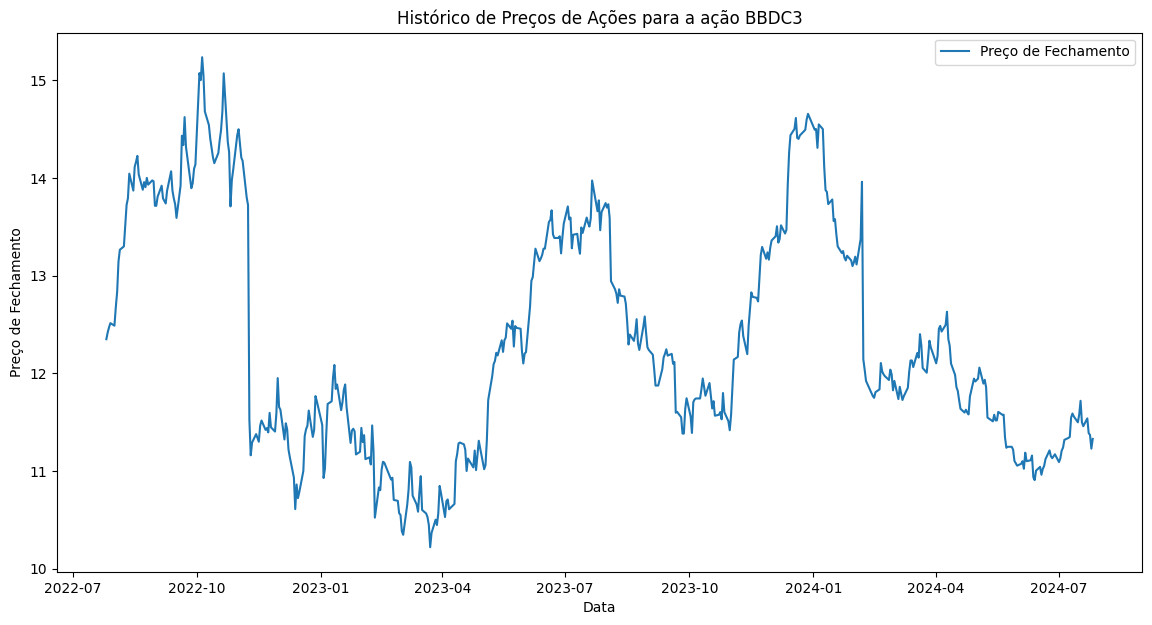

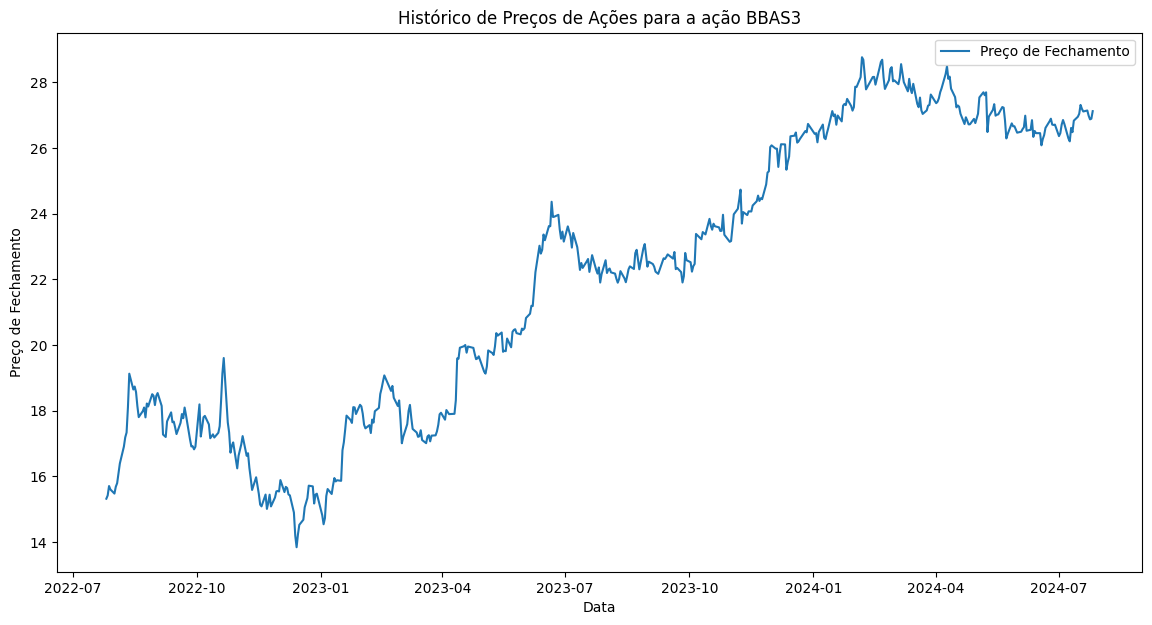

In [ ]:

plot_precos(acoes,precos_acoes, 'Data', 'Preco_close')

In [ ]:
precos_ajustados = pre_process_precos(precos_acoes,acoes, 'Preco_close', 'Data')
print(precos_ajustados)

Valores faltantes por coluna: 0
Valores faltantes por coluna: 0
                           Preco_close    ticker  coluna_preco_scaled
Data                                                                 
2022-07-26 00:00:00-03:00    12.350903  BBDC3.SA             0.114870
2022-07-27 00:00:00-03:00    12.420094  BBDC3.SA             0.118601
2022-07-28 00:00:00-03:00    12.471989  BBDC3.SA             0.121400
2022-07-29 00:00:00-03:00    12.515232  BBDC3.SA             0.123732
2022-08-01 00:00:00-03:00    12.489289  BBDC3.SA             0.122333
...                                ...       ...                  ...
2024-07-22 00:00:00-03:00    27.139999  BBAS3.SA             0.912483
2024-07-23 00:00:00-03:00    26.980000  BBAS3.SA             0.903854
2024-07-24 00:00:00-03:00    26.870001  BBAS3.SA             0.897922
2024-07-25 00:00:00-03:00    26.889999  BBAS3.SA             0.899000
2024-07-26 00:00:00-03:00    27.120001  BBAS3.SA             0.911405

[1002 rows x 3 columns]
